In [1]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

   cluster_Et  cluster_Eta  cluster_Phi   vertexz  e11_over_e33  e32_over_e35  \
0     20.8799     0.206139     -1.72089  16.55830      0.281623      0.659279   
1     13.9776    -0.576073     -2.08968  10.63310      0.488148      0.920728   
2     13.5286    -0.472755      2.57658  10.63310      0.484768      0.982290   
3     12.6726    -0.373349      0.24158   4.62037      0.547630      0.909671   
4     11.5242     0.178649     -2.85107   4.62037      0.595076      0.974657   

   cluster_prob  cluster_weta_cogx  cluster_wphi_cogx  cluster_et1  \
0      0.000000           1.037100           1.414230     0.464623   
1      0.000529           0.373134           0.164927     0.902859   
2      0.512407           0.145486           0.189375     0.962977   
3      0.000000           0.406615           0.448302     0.805753   
4      0.001675           0.338378           0.217013     0.944487   

   cluster_et2  cluster_et3  cluster_et4  is_tight  pid  
0    -0.007836     0.181806     0.

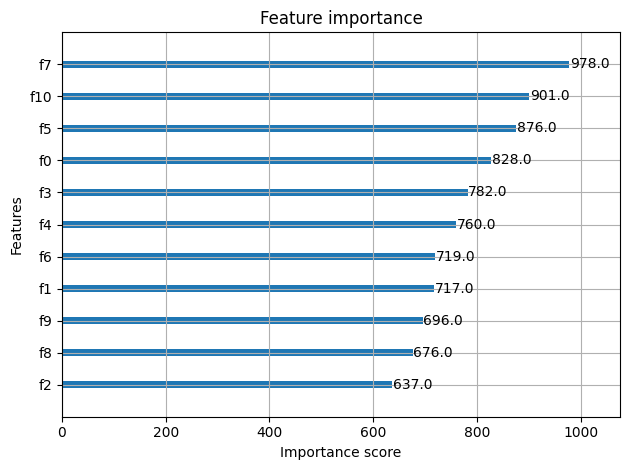

In [27]:
# Step 1: Load data
filename = "shapes_jet30.txt"  
columns = [
    "cluster_Et", "cluster_Eta", "cluster_Phi", "vertexz"
    "e11_over_e33", "e32_over_e35",
    "cluster_prob", "cluster_weta_cogx", "cluster_wphi_cogx",
    "cluster_et1", "cluster_et2", "cluster_et3", "cluster_et4",
    "is_tight", "pid"
]

df = pd.read_csv("shapes_jet30.txt", sep=r"\s+", header=0)
print(df.head())
# Step 2: Label: 1 if photon (pid==22), else 0
df["pid"] = pd.to_numeric(df["pid"], errors='coerce')
df["label"] = (df["pid"] == 22).astype(int)

# Step 3: Select features for training
features = [
    "cluster_Et", "cluster_Eta", "vertexz", "e11_over_e33", "e32_over_e35", "cluster_weta_cogx", "cluster_wphi_cogx",
    "cluster_et1", "cluster_et2", "cluster_et3", "cluster_et4",
]
for col in features:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df.dropna(subset=features + ["label"], inplace=True)

X = df[features].to_numpy(dtype=np.float32)   #  ⇦  NumPy instead of DataFrame
y = df["label"].to_numpy(dtype=np.int32)

# Step 4: Train/test split (now returns NumPy arrays)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# label distribution check
unique, counts = np.unique(y_train, return_counts=True)
print("Label counts:", dict(zip(unique, counts)))


# Step 5: Train a BDT with XGBoost
model = xgb.XGBClassifier(
    max_depth=5,              # try 2–10
    n_estimators=300,         # more trees, pair with lower learning rate
    learning_rate=0.05,       # try 0.01–0.3
    subsample=0.8,            # randomly sample 80% of training examples per tree
    colsample_bytree=0.8,     # randomly sample 80% of features per tree
    gamma=1,                  # min loss reduction to split, helps prune
    reg_alpha=1,              # L1 regularization on weights
    reg_lambda=1,             # L2 regularization on weights
    scale_pos_weight=30,       # handle class imbalance (auto-tune from class counts)
    eval_metric='auc',
)
model.fit(X_train, y_train)

# Step 6: Evaluate
y_pred = model.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Optional: Feature importance plot
import matplotlib.pyplot as plt
xgb.plot_importance(model)
plt.tight_layout()
plt.show()



--- BDT score summary ---
 Signal:   n=   3953   mean=0.654   min=0.054   max=0.988
 Bkgd:     n=  97987   mean=0.385   min=0.020   max=0.988


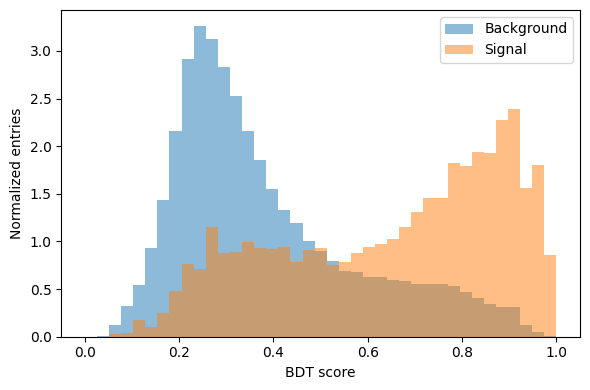

In [28]:
# ---------------------------------------------------------------
# Block 7 – Inspect BDT scores for signal vs. background
# ---------------------------------------------------------------

# 1. Continuous BDT scores (probability for class 1)
score_test = model.predict_proba(X_test)[:, 1]   # shape (N_test,)

# 2. Split by truth label
sig_mask = y_test == 1
bkg_mask = y_test == 0

sig_scores = score_test[sig_mask]
bkg_scores = score_test[bkg_mask]

# 3. Quick numerical summary
import numpy as np
print("\n--- BDT score summary ---")
print(f" Signal:   n={sig_scores.size:7d}   mean={sig_scores.mean():.3f}   "
      f"min={sig_scores.min():.3f}   max={sig_scores.max():.3f}")
print(f" Bkgd:     n={bkg_scores.size:7d}   mean={bkg_scores.mean():.3f}   "
      f"min={bkg_scores.min():.3f}   max={bkg_scores.max():.3f}")

# 4. Optional: overlaid histograms
import matplotlib.pyplot as plt
bins = np.linspace(0, 1, 40)  # 0–1 probability range

plt.figure(figsize=(6,4))
plt.hist(bkg_scores, bins=bins, alpha=0.5, label="Background", density=True)
plt.hist(sig_scores, bins=bins, alpha=0.5, label="Signal",     density=True)
plt.xlabel("BDT score")
plt.ylabel("Normalized entries")
plt.legend()
plt.tight_layout()
plt.show()


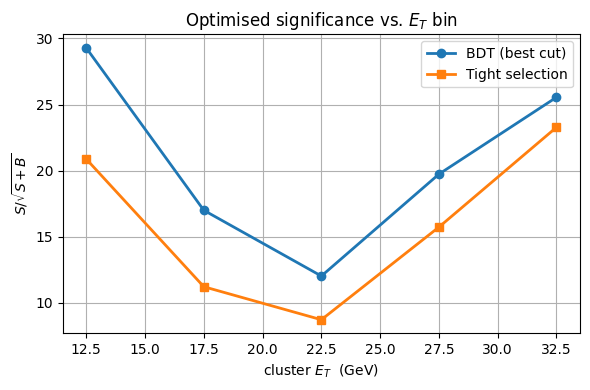

In [29]:
# ---------------------------------------------------------------
# Block ➊ – compute max-BDT and tight-cut significance per Et bin
# ---------------------------------------------------------------
import numpy as np

bin_centres      = []
sig_best_bdt     = []   # optimal BDT cut
sig_tight        = []   # fixed tight selection

for i in range(len(et_bins) - 1):
    et_min, et_max = et_bins[i], et_bins[i + 1]
    mask = (df["cluster_Et"] >= et_min) & (df["cluster_Et"] < et_max)
    if mask.sum() < 100:
        continue

    y_bin      = y[mask]                                # 0 / 1
    scores_bin = model.predict_proba(X[mask])[:, 1]
    tight_bin  = df.loc[mask, "is_tight"].to_numpy(dtype=np.int8)

    # --- 1. scan score thresholds for BDT
    best = 0.0
    thr  = np.linspace(0, 1, 201)
    for t in thr:
        S = np.sum((scores_bin >= t) & (y_bin == 1))
        B = np.sum((scores_bin >= t) & (y_bin == 0))
        if S + B:
            z = S / np.sqrt(S + B)
            if z > best:
                best = z
    sig_best_bdt.append(best)

    # --- 2. significance for *tight* flag
    S_t = np.sum((tight_bin == 1) & (y_bin == 1))
    B_t = np.sum((tight_bin == 1) & (y_bin == 0))
    z_t = S_t / np.sqrt(S_t + B_t) if (S_t + B_t) else 0.0
    sig_tight.append(z_t)

    bin_centres.append(0.5 * (et_min + et_max))

# ---------------------------------------------------------------
# Block ➋ – overlay plot
# ---------------------------------------------------------------
plt.figure(figsize=(6,4))
plt.plot(bin_centres, sig_best_bdt, marker="o", lw=2,
         label="BDT (best cut)")
plt.plot(bin_centres, sig_tight, marker="s", lw=2,
         label="Tight selection")
plt.xlabel(r"cluster $E_T$  (GeV)")
plt.ylabel(r"$S/\sqrt{S+B}$")
plt.title("Optimised significance vs. $E_T$ bin")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


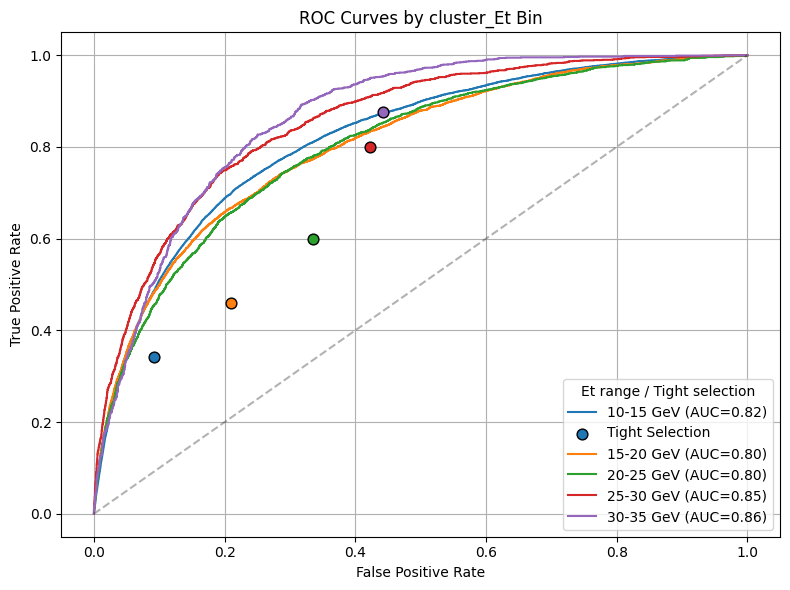

In [31]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Define Et bins
et_bins = [10, 15, 20, 25, 30, 35]

# Start the plot
plt.figure(figsize=(8, 6))

# Flag to add tight legend only once
tight_legend_added = False

for i in range(len(et_bins) - 1):
    et_min = et_bins[i]
    et_max = et_bins[i + 1]

    mask = (df["cluster_Et"] >= et_min) & (df["cluster_Et"] < et_max)
    if mask.sum() < 100:
        continue

    X_bin = df.loc[mask, features]
    y_bin = df.loc[mask, "label"]
    tight_bin = df.loc[mask, "is_tight"].astype(int)

    bdt_probs = model.predict_proba(X_bin)[:, 1]

    fpr_bdt, tpr_bdt, _ = roc_curve(y_bin, bdt_probs)
    auc_bdt = auc(fpr_bdt, tpr_bdt)

    # Plot ROC curve and extract color
    line, = plt.plot(fpr_bdt, tpr_bdt, label=f"{et_min}-{et_max} GeV (AUC={auc_bdt:.2f})")
    roc_color = line.get_color()

    # Tight point
    fpr_tight, tpr_tight, _ = roc_curve(y_bin, tight_bin)
    plt.scatter(
        fpr_tight[1], tpr_tight[1],
        color=roc_color, edgecolor='black', s=60,
        label="Tight Selection" if not tight_legend_added else None,
        zorder=5
    )
    tight_legend_added = True  # only label the first time

# Reference line
plt.plot([0, 1], [0, 1], 'k--', alpha=0.3)

# Labels and legend
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves by cluster_Et Bin")
plt.legend(title="Et range / Tight selection", loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


In [32]:
model.save_model("bdt.json") 

In [33]:
import ROOT
ROOT.TMVA.Experimental.SaveXGBoost(          # pythonized helper
        model,                  # xgboost.Booster
        "myBDT",                        
        "myBDT.root",
        num_inputs=11)